In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
df=pd.read_csv("/content/water_dataX1.csv")

df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df['PH'] = pd.to_numeric(df['PH'], errors='coerce')
df['D.O.'] = pd.to_numeric(df['D.O.'], errors='coerce')
df['CONDUCTIVITY'] = pd.to_numeric(df['CONDUCTIVITY'], errors='coerce')
df['NITRATENAN N+ NITRITENANN'] = pd.to_numeric(df['NITRATENAN N+ NITRITENANN'], errors='coerce')
df['FECAL COLIFORM'] = pd.to_numeric(df['FECAL COLIFORM'], errors='coerce')
df['B.O.D.'] = pd.to_numeric(df['B.O.D.'], errors='coerce')

imputer_temp = SimpleImputer(strategy='constant', fill_value=25)
imputer_ph = SimpleImputer(strategy='constant', fill_value=7)
imputer_do = SimpleImputer(strategy='constant', fill_value=7.2)
imputer_conductivity = SimpleImputer(strategy='constant', fill_value=500)
imputer_nitrate = SimpleImputer(strategy='constant', fill_value=0.5)
imputer_fecal = SimpleImputer(strategy='constant', fill_value=100)
imputer_bod = SimpleImputer(strategy='constant', fill_value=2)

# Apply imputation on respective columns
df['Temp'] = imputer_temp.fit_transform(df[['Temp']])
df['PH'] = imputer_ph.fit_transform(df[['PH']])
df['D.O.'] = imputer_do.fit_transform(df[['D.O.']])
df['CONDUCTIVITY'] = imputer_conductivity.fit_transform(df[['CONDUCTIVITY']])
df['NITRATENAN N+ NITRITENANN'] = imputer_nitrate.fit_transform(df[['NITRATENAN N+ NITRITENANN']])
df['FECAL COLIFORM'] = imputer_fecal.fit_transform(df[['FECAL COLIFORM']])
df['B.O.D.'] = imputer_bod.fit_transform(df[['B.O.D.']])


def pure_impure(row):
  thresholds={'Temp':(0,30),
              'D.O.':6, #min do
              'PH':(6.5,8.5), #ideal ph range
              'CONDUCTIVITY':1000, #max conductivity
              'B.O.D.':7, #bod max
              'NITRATENAN N+ NITRITENANN':1, #max nitrite in mg/L
              'FECAL COLIFORM':1000} #should be absent in drinking water

  if not (thresholds['Temp'][0] <= row['Temp'] <= thresholds['Temp'][1]):
      return "Impure"
  if not (thresholds['PH'][0] <= row['PH'] <= thresholds['PH'][1]):
      return "Impure"
  if row['D.O.'] < thresholds['D.O.']:
      return "Impure"
  if row['CONDUCTIVITY'] > thresholds['CONDUCTIVITY']:
      return "Impure"
  if row['B.O.D.'] > thresholds['B.O.D.']:
      return "Impure"
  if row['NITRATENAN N+ NITRITENANN'] > thresholds['NITRATENAN N+ NITRITENANN']:
      return "Impure"
  if row['FECAL COLIFORM'] > thresholds['FECAL COLIFORM']:
      return "Impure"

  return "Pure"

# print(pd.DataFrame(df))
df['Water Quality'] = df.apply(pure_impure, axis=1)
print(df.head())
df.to_csv('pure_impure_water_quality.csv', index=False)
print('Data saved in pure_impure_water_quality.csv')

  STATION CODE                                          LOCATIONS  \
0         1393               DAMANGANGA AT D/S OF MADHUBAN, DAMAN   
1         1399  ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...   
2         1475                                ZUARI AT PANCHAWADI   
3         3181                        RIVER ZUARI AT BORIM BRIDGE   
4         3182                       RIVER ZUARI AT MARCAIM JETTY   

         STATE  Temp  D.O.   PH  CONDUCTIVITY  B.O.D.  \
0  DAMAN & DIU  30.6   6.7  7.5         203.0     2.0   
1          GOA  29.8   5.7  7.2         189.0     2.0   
2          GOA  29.5   6.3  6.9         179.0     1.7   
3          GOA  29.7   5.8  6.9          64.0     3.8   
4          GOA  29.5   5.8  7.3          83.0     1.9   

   NITRATENAN N+ NITRITENANN  FECAL COLIFORM Water Quality  
0                        0.1            11.0        Impure  
1                        0.2          4953.0        Impure  
2                        0.1          3243.0        Impure 

In [ ]:
df.groupby('Water Quality').size()

,0
Water Quality,
Impure,1271
Pure,720


In [ ]:
import pandas as pd
df=pd.read_csv("/content/pure_impure_water_quality.csv")
print(df['Water Quality'].value_counts())

Water Quality
Impure    1271
Pure       720
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

print("Class distribution in target (Water Quality):")
print(df['Water Quality'].value_counts())

# Separate features and target
X = df.drop(['Water Quality', 'STATE', 'STATION CODE', 'LOCATIONS'], axis=1)
y = df['Water Quality']

# Convert target labels to binary (1: Pure, 0: Impure)
y = y.apply(lambda x: 1 if x == 'Pure' else 0)


Class distribution in target (Water Quality):
Water Quality
Impure    1271
Pure       720
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_model = GradientBoostingClassifier(random_state=42)

test_accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train your model as usual
    gb_model.fit(X_train, y_train)

    y_pred=gb_model.predict(X_test)

    accuracy=accuracy_score(y_test,y_pred)
    test_accuracies.append(accuracy)

# Compute the mean accuracy over all folds
mean_accuracy = np.mean(test_accuracies)

# Print the accuracies for each fold and the mean accuracy
print(f"Test accuracies for each fold: {test_accuracies}")
print(f"Mean test accuracy: {mean_accuracy}")

Test accuracies for each fold: [1.0, 0.9974874371859297, 0.9974874371859297, 0.9899497487437185, 1.0]
Mean test accuracy: 0.9969849246231156


In [ ]:
from sklearn.metrics import classification_report
y_pred=gb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       144

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



'\n# Evaluate the model\nprint(confusion_matrix(y_test, y_pred))\nprint(classification_report(y_test, y_pred))\n'

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.99498747 1.         0.99246231 0.99748744 0.99748744]
Mean CV Score: 0.9964849309202656


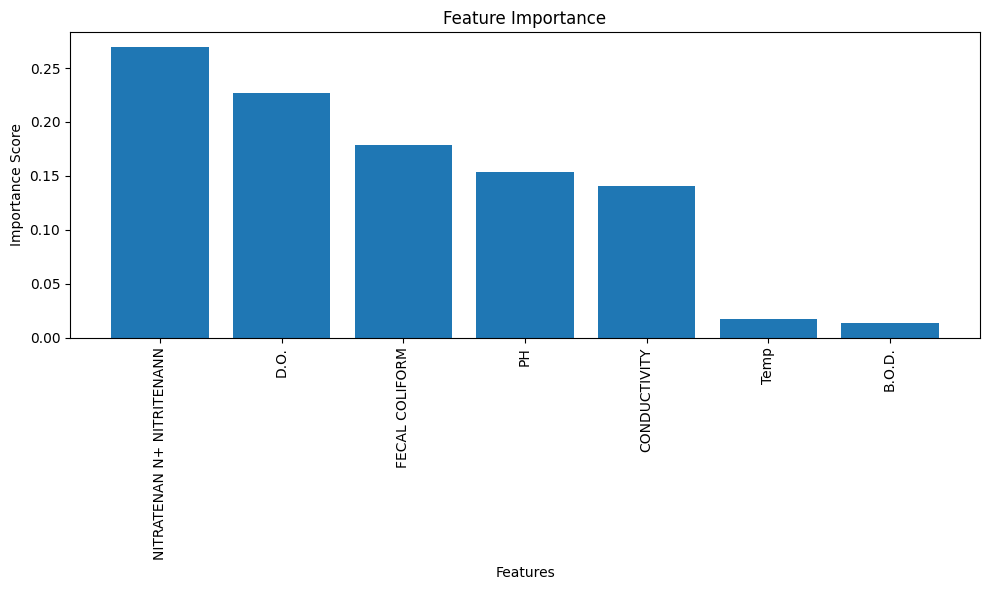

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = gb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [ ]:

import numpy as np

original_features = X.columns
feature_importances = gb_model.feature_importances_
important_features = np.array(original_features)[np.argsort(feature_importances)[::-1]]

# Display the features sorted by importance
for feature, importance in zip(important_features, sorted(feature_importances, reverse=True)):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


Feature: NITRATENAN N+ NITRITENANN, Importance: 0.2696
Feature: D.O., Importance: 0.2269
Feature: FECAL COLIFORM, Importance: 0.1787
Feature: PH, Importance: 0.1533
Feature: CONDUCTIVITY, Importance: 0.1403
Feature: Temp, Importance: 0.0175
Feature: B.O.D., Importance: 0.0137


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Initialize an empty dictionary to store the most important feature for each location
location_feature_importance = {}

# Group data by location (e.g., 'LOCATIONS')
location_groups = df.groupby('LOCATIONS')

# Loop through each location group
for location, data in location_groups:
    # Separate features and target variable
    X_location = data.drop(['Water Quality', 'STATE', 'LOCATIONS'], axis=1)  # Drop unnecessary columns
    y_location = data['Water Quality'].apply(lambda x: 1 if x == 'Pure' else 0)  # Encode target variable as 0 and 1

    # Impute missing values (mean strategy for simplicity)
    imputer = SimpleImputer(strategy='mean')
    X_location_imputed = imputer.fit_transform(X_location)

    # Check if the location has only one class
    unique_classes = y_location.unique()

    if len(unique_classes) == 1:
        if unique_classes[0] == 0:
            # Location is all "Impure", find the feature contributing to impurity
            impurity_feature_means = X_location.mean().sort_values(ascending=False)
            most_important_feature = impurity_feature_means.idxmax()  # Feature with the highest mean for impurity
            print(f"Location {location} Most important feature: {most_important_feature}")
            location_feature_importance[location] = most_important_feature
        else:
            # Skip locations with all pure water quality samples
            print(f"Location {location} contains only 'Pure' samples. Skipping.")
    else:
        # Train the Gradient Boosting model for locations with both pure and impure samples
        gb_model_location = GradientBoostingClassifier(n_estimators=100, random_state=42)
        gb_model_location.fit(X_location_imputed, y_location)

        # Extract feature importances for the location
        feature_importances = gb_model_location.feature_importances_

        # Get the most important feature
        most_important_feature = X_location.columns[np.argmax(feature_importances)]

        # Store the most important feature for the location
        location_feature_importance[location] = most_important_feature

# Display the most important feature for each location
for location, feature in location_feature_importance.items():
    print(f"Location: {location}, Most Important Feature: {feature}")

# Optional: Save the location-wise important features to a CSV file
df_location_importances = pd.DataFrame(list(location_feature_importance.items()), columns=['Location', 'Most Important Feature'])
df_location_importances.to_csv('location_wise_important_features.csv', index=False)
print("Location-wise important features saved to 'location_wise_important_features.csv'")


Location ACHENKOIL AT CHENNITHULA Most important feature: FECAL COLIFORM
Location ACHENKOIL AT CHENNITHULA, KERALA Most important feature: FECAL COLIFORM
Location ACHENKOIL AT KALLARAKADAVU, PATHANAMTHITTA Most important feature: FECAL COLIFORM
Location ACHENKOIL AT PANDALAM (NEAR AYYAPPA TEMPLE), PATHANAMTHITTA Most important feature: FECAL COLIFORM
Location ACHENKOIL AT PANDALAM (NEAR AYYAPPA TEMPLE),PATHANAMTHITTA Most important feature: FECAL COLIFORM
Location ACHENKOIL AT THUMPAMON Most important feature: FECAL COLIFORM
Location ACHENKOIL AT THUMPAMON, KERALA Most important feature: FECAL COLIFORM
Location AMARAVILA Most important feature: FECAL COLIFORM
Location AMARAVILA, KERALA Most important feature: FECAL COLIFORM
Location AMBA AT D/S OF WAKEN BDG U/S OF JS PETROCHEMICALS, WAKENPHATA, ROHA Most important feature: FECAL COLIFORM
Location AMBA AT D/S OF WAKEN BRIDGENANU/S OF JS PETROCHEMICALS, WAKENPHATA, ROHA Most important feature: CONDUCTIVITY
Location AMBA RIVER AT D/S OF W

In [ ]:
def calculate_impurity_score(row):
    score = 0
    thresholds = {'PH': (6.5, 8.5), 'D.O.': 6, 'CONDUCTIVITY': 500, 'B.O.D.': 2, 'NITRATENAN N+ NITRITENANN': 1, 'FECAL COLIFORM': 0}
    for col, threshold in thresholds.items():
        if isinstance(threshold, tuple):
            if not (threshold[0] <= row[col] <= threshold[1]):
                score += abs(row[col] - sum(threshold) / 2)  # Deviation from the middle of the acceptable range
        else:
            if row[col] > threshold:
                score += row[col] - threshold  # Deviation from the upper threshold
    return score

# Apply the impurity score calculation to the dataset
df['Impurity_Score'] = df.apply(calculate_impurity_score, axis=1)
output_file_path = 'water_quality_with_impurity_scores.csv'
df.to_csv(output_file_path, index=False)

print(f"New CSV file created at: {output_file_path}")

New CSV file created at: water_quality_with_impurity_scores.csv


In [ ]:
from sklearn.impute import SimpleImputer
new_data = 'water_quality_with_impurity_scores.csv'
df_new=pd.read_csv(new_data)

original_features = list(X.columns)  # X is the DataFrame used during training

# Drop unnecessary columns from the new data
df_new_filtered = df_new[original_features]

# Check for missing columns in the new data that were in the training set
for col in original_features:
    if col not in df_new_filtered.columns:
        df_new_filtered[col] = 0  # or use the mean value from the training set

# Ensure the columns are in the same order as in the training set
df_new_filtered = df_new_filtered[original_features]

#Impute missing values using the mean
imputer=SimpleImputer(strategy='mean')
df_new_filtered=pd.DataFrame(imputer.fit_transform(df_new_filtered),columns=df_new_filtered.columns)

# Apply the model to the new data
predictions = rf_model_regularized.predict(df_new_filtered)

# Add the predictions to the new dataset
df_new['Predicted_Water_Quality'] = predictions

output_path = 'new_data_with_predictions.csv'
df_new.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")

Predictions saved to: new_data_with_predictions.csv
